In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

Since I want to test a bunch of models out, I made this function to automate the process of training and reporting accuracy.  This is possible because sklearn provides a very consistent api for regression models.  Yay duck typing!  A couple things to note:

Two separate models are trained, one for each team's score.  Many sklearn models do support regression on multiple values, but some do not.  For those that do, combining does not seem to improve performance much anyways, so not much is lost here.

Data is separated into a pre-2015 training set and 2015-onwards test set.  I think this is more compelling than pulling the test set randomly over the entire history of seasons, since predicting future games is a much more realistic application for such a regression.

Scores are reported in two ways, first as a coefficient R^2, then as a percent of games predicted within 7 points.  The percent of games within 7 points is included because it gives a more intuitive sense of how well our predictions are working.

In [2]:
def run_model(model_name, model_factory, data, x_cols):
    historic_nfl = data.query('season < 2015')

    X_train = historic_nfl[x_cols]
    Y1_train = historic_nfl['score1']
    Y2_train = historic_nfl['score2']

    current_nfl = data.query('season >= 2015')

    X_test = current_nfl[x_cols]
    Y1_test = current_nfl['score1']
    Y2_test = current_nfl['score2']
    
    lr1 = model_factory()
    lr1.fit(X_train, Y1_train)
    acc1 = lr1.score(X_test, Y1_test)

    lr2 = model_factory()
    lr2.fit(X_train, Y2_train)
    acc2 = lr2.score(X_test, Y2_test)
    
    close = 0
    preds1 = lr1.predict(X_test)
    preds2 = lr2.predict(X_test)
    for actual, pred in zip(data['score1'], preds1):
        if abs(actual - pred) <= 7:
            close += 1
    
    for actual, pred in zip(data['score2'], preds2):
        if abs(actual - pred) <= 7:
            close += 1
    
    
    print(model_name)
    print('=======================')
    print(f'Model score on score1: {acc1}')
    print(f'Model score on score2: {acc2}')
    print(f'Percent of predictions within 7 points of actual: {close / (2 * len(X_test))}')
    print()

# Data Exploration

From the first glance at the data, some things to note:
* the home-field team is 'team1'.  If a homefield advantage exists, our models should be able to use this
* date looks like it could be useful if combined with other datasets, but maybe not right now
* ties are possible, denoted as a '0.5' in result1

In [3]:
nfl_data = pd.read_csv('data/nfl_games.csv')
nfl_data.head()

,date,season,neutral,playoff,team1,team2,elo1,elo2,elo_prob1,score1,score2,result1
0,1920-09-26,1920,0,0,RII,STP,1503.947,1300.000,0.824651,48,0,1.0
1,1920-10-03,1920,0,0,AKR,WHE,1503.420,1300.000,0.824212,43,0,1.0
2,1920-10-03,1920,0,0,RCH,ABU,1503.420,1300.000,0.824212,10,0,1.0
3,1920-10-03,1920,0,0,DAY,COL,1493.002,1504.908,0.575819,14,0,1.0
4,1920-10-03,1920,0,0,RII,MUN,1516.108,1478.004,0.644171,45,0,1.0


A definite, if messy correlation between elo and score exists.  Good sign that we may have some success doing regression on this data point.

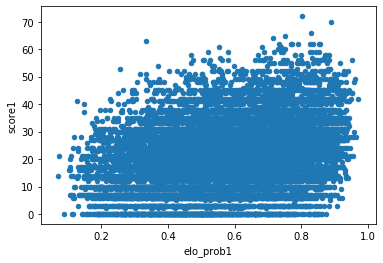

In [4]:
nfl_data.plot.scatter(x='elo_prob1', y='score1')

This chart helps give some insights into the tricky nature of our data.  The distribution of football scores tend to be defined by increments of 3 and 7, a fact almost certainly lost on any regression model we might attempt to use.

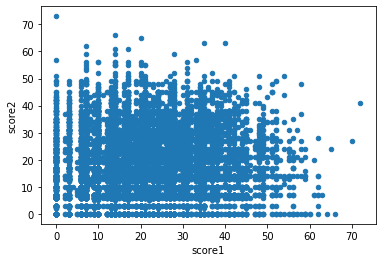

In [5]:
nfl_data.plot.scatter(x='score1', y='score2')

Interestingly, this chart makes the case for including season in the regression -- scores can be clearly seen to vary over time.  There are a number of reasons why this could be the case: changes in rules, evolution of training techniques, etc.

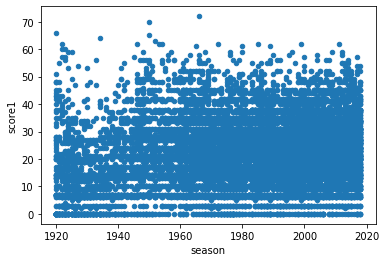

In [6]:
nfl_data.plot.scatter(x='season', y='score1')

# Models

To get a baseline, we'll do some regression without any feature engineering.  Pretty much all of the data is included, with the exception of date and teams (more on that later).  A bit on the models I used:

* Linear Regression is a classic, and blazing fast.  I like to use it as a baseline of what's possible, and it actually performs pretty well on this data.
* Random Forests have given me good results in the past, and also work very quickly.
* Gradient Boosting is a little more experiemental for me, but seems to produce good R^2 values even if it takes a bit longer to do so.

The results are decent, with some models clearly performing better than others.  Interestingly, while the Random Forest has the worst R^2 value, it actually predicts more games within 7 points than the other models.

I originally also ran a neural network alongside the other three, but it produced awful results and ran for about ten times as long as the others.

In [7]:
run_model('Linear Regression', LinearRegression, nfl_data, ['season', 'neutral', 'playoff', 'elo1', 'elo2', 'elo_prob1', 'result1'])
run_model('Random Forest', RandomForestRegressor, nfl_data, ['season', 'neutral', 'playoff', 'elo1', 'elo2', 'elo_prob1', 'result1'])
run_model('Gradient Boosting', GradientBoostingRegressor, nfl_data, ['season', 'neutral', 'playoff', 'elo1', 'elo2', 'elo_prob1', 'result1'])

Linear Regression
Model score on score1: 0.31382817953038944
Model score on score2: 0.26983191411124274
Percent of predictions within 7 points of actual: 0.16432584269662923



/home/alex/EECS_731/p4/data/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/EECS_731/p4/data/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest
Model score on score1: 0.18308168295592775
Model score on score2: 0.15262836519773393
Percent of predictions within 7 points of actual: 0.18773408239700373

Gradient Boosting
Model score on score1: 0.3218172512535998
Model score on score2: 0.2823022831930746
Percent of predictions within 7 points of actual: 0.17228464419475656



# Feature Engineering

There's one very obvious omission from our first attempt: we're not doing anything with our team data.  It makes sense that some teams are better than others at offense or defense, and that some teams are particularly good or bad at playing certain other teams.  Let's do a one-hot encoding of our team data and add that to the dataset.

In [8]:
onehot_team1 = pd.get_dummies(nfl_data['team1'], prefix='team1', sparse=True)
onehot_team2 = pd.get_dummies(nfl_data['team2'], prefix='team2', sparse=True)
nfl_data_teams = pd.concat([nfl_data, onehot_team1, onehot_team2], axis=1)

team_cols = list(onehot_team1.columns) + list(onehot_team2.columns)

Good!  It looks like adding team data afforded modest returns.  Interestingly, it looks as though the biggest improvements were in the R^2 values, not in the within-7 percent.  Perhaps this means that adding team data cut down mostly on severely inaccurate predictions.

In [9]:
train_cols = ['season', 'neutral', 'playoff', 'elo1', 'elo2', 'elo_prob1', 'result1'] + team_cols
run_model('Linear Regression', LinearRegression, nfl_data_teams, train_cols)
run_model('Random Forest', RandomForestRegressor, nfl_data_teams, train_cols)
run_model('Gradient Boost', GradientBoostingRegressor, nfl_data_teams, train_cols)

Linear Regression
Model score on score1: 0.3046805605749244
Model score on score2: 0.2675299505087375
Percent of predictions within 7 points of actual: 0.18164794007490637



/home/alex/EECS_731/p4/data/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/EECS_731/p4/data/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest
Model score on score1: 0.22037019333784957
Model score on score2: 0.17311524598949202
Percent of predictions within 7 points of actual: 0.18679775280898878

Gradient Boost
Model score on score1: 0.3300580201155243
Model score on score2: 0.2863057308776814
Percent of predictions within 7 points of actual: 0.17368913857677903



What else might be helpful?  One possiblility is how long of a winning streak each team is on going into each game.  Perhaps teams on a hot streak are more likely to be high-scoring.  For this analysis we ignore ties, leaving the streak status of each team unchanged.

In [10]:
streaks = {team: 0 for team in nfl_data['team1'].append(nfl_data['team2']).unique()}

frames = []
for _, row in nfl_data.iterrows():
    frames.append(
        pd.DataFrame({'team1_streak': [streaks[row['team1']]], 'team2_streak': [streaks[row['team2']]]})
    )
    
    if row['result1'] == 1.0:
        streaks[row['team1']] += 1
        streaks[row['team2']] = 0
    elif row['result1'] == 0.0:
        streaks[row['team1']] = 0
        streaks[row['team2']] += 1

team_streaks = pd.concat(frames, ignore_index=True)

In [11]:
nfl_data_streaks = pd.concat([nfl_data_teams, team_streaks], axis=1)

Hmm, it's ambiguous if adding streaks really improved anything.  Some numbers got better, others got worse.  It's worth noting that streak numbers don't reset at the end of each season, and this may be adding noise.  Computing losing streaks may also return results.

In [12]:
train_cols = ['season', 'neutral', 'playoff', 'elo1', 'elo2', 'elo_prob1', 'result1', 'team1_streak', 'team2_streak'] + team_cols
run_model('Linear Regression', LinearRegression, nfl_data_streaks, train_cols)
run_model('Random Forest', RandomForestRegressor, nfl_data_streaks, train_cols)
run_model('Gradient Boost', GradientBoostingRegressor, nfl_data_streaks, train_cols)

Linear Regression
Model score on score1: 0.30348582875903063
Model score on score2: 0.2674910226385758
Percent of predictions within 7 points of actual: 0.18164794007490637



/home/alex/EECS_731/p4/data/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/alex/EECS_731/p4/data/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest
Model score on score1: 0.19852520358333092
Model score on score2: 0.20421208792440726
Percent of predictions within 7 points of actual: 0.17743445692883894

Gradient Boost
Model score on score1: 0.32790443126153423
Model score on score2: 0.28434879120086487
Percent of predictions within 7 points of actual: 0.17415730337078653



# Conclusion

The results of our regression are ok, but not stellar.  The best performer seems to be the Random Forest, which predicts about 18% of games within 7 points of the actual score.  Feature engineering returned modest results, but I'm left feeling as though there was something better hiding in the data.

Another interesting approach could be combining this data with historical weather data.  Temperature and precipitation likely play a major role in how many points are scored during a game, since football is generally played outdoors.